In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

## Anomaly detection

In [314]:
data = loadmat('ex8/ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].ravel()
print(X.shape)

(307, 2)


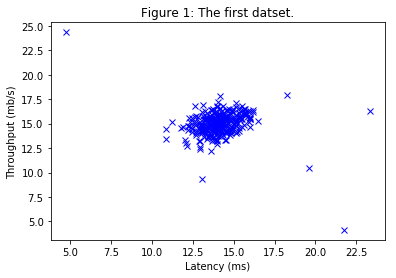

In [6]:
plt.plot(X[:,0], X[:,1], 'bx')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Figure 1: The first datset.')
plt.show()

### Gaussian distribution

### Estimating parameters for a Gaussian

In [279]:
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.std(X, axis=0)**2
    #m = X.shape[0]
    #mu = np.sum(X, axis=0) / m
    #sigma2 = np.sum(np.square(X-mu), axis=0) / m
    return (mu, sigma2)

In [280]:
mu, sigma2 = estimateGaussian(X)

In [287]:
def multivariateGaussian(X, mu, Sigma2):
    '''
    Compute the probability density function of the examples X 
    under the emultivariate gaussian distribution with parameters mu and Sigma2.
    
    If Sigma2 is a matrix, it is treated as the covariance matrix. If Sigma2 is a vector,
    it is treated as the values of the variance in each dimension (a diagonal covariance matrix)
    '''
    k = len(mu)
    X = np.array(X)
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    if (len(Sigma2.shape) == 1) or (1 in Sigma2.shape):
        Sigma2 = np.diagflat(Sigma2)
    Sigma2_det = np.linalg.det(Sigma2)
    Sigma2_inv = np.linalg.inv(Sigma2)
    u = ((2*np.pi)**k * Sigma2_det)**(-0.5)
    e = X - mu
    v = np.sum(np.dot(e, Sigma2_inv) * e, axis=1) # (x-mu)T.dot(Sigma_inv) * (x-mu)
    p =  u * np.exp(-0.5 * v)
    return p

In [290]:
N = 300
x1 = np.linspace(0, 30, N)
x2 = np.linspace(0, 30, N)
X1, X2 = np.meshgrid(x1, x2)
Z_contour = multivariateGaussian(np.c_[X1.ravel(), X2.ravel()], mu, sigma2)
Z_contour = Z_contour.reshape(X1.shape)

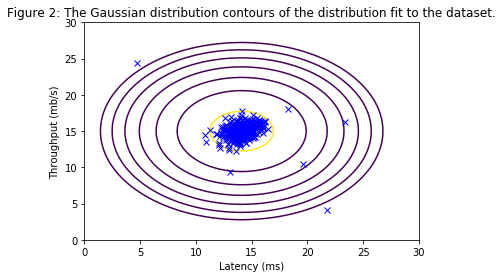

In [293]:
plt.plot(X[:,0], X[:,1], 'bx')
plt.contour(X1, X2, Z_contour, levels=10.0**np.arange(-20,0,3))

plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Figure 2: The Gaussian distribution contours of the distribution fit to the dataset.')
plt.show()

### Selecting the threshold, epsilon

In [341]:
def selectThreshold(yval, pval):
    '''
    Find the best threshold (epsilon) to use for selecting outliers 
    based on the results (F1 score) from a validation set (pval) and the ground truth (yval)
    '''
    bestEpsilon = 0
    bestF1 = 0
    maxp, minp = max(pval), min(pval)
    for epsilon in np.arange(minp, maxp, (maxp-minp)/1000):
        pred = (pval < epsilon)
        tp = sum(pred & yval)
        fp = sum(pred) - tp
        fn = sum(yval) - tp
        prec = tp / (tp + fp + 1e-8)
        rec = tp / (tp + fn + 1e-8)
        F1 = 2 * prec * rec / (prec + rec + 1e-8)
        if F1 > bestF1:
            bestEpsilon = epsilon
            bestF1 = F1
    return (bestEpsilon, bestF1)

In [342]:
pval = multivariateGaussian(Xval, mu, sigma2)

In [352]:
epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: {}'.format(round(epsilon, 7)))
print('Best F1 on Cross Validation Set:  {}'.format(round(F1, 3)))
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

Best epsilon found using cross-validation: 8.99e-05
Best F1 on Cross Validation Set:  0.875
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


In [353]:
p = multivariateGaussian(X, mu, sigma2)
outliers = (p < epsilon)

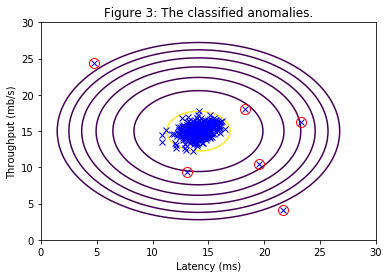

In [365]:
plt.plot(X[:,0], X[:,1], 'bx')
plt.plot(X[outliers,0], X[outliers,1], 'ro', mfc='none', markersize=10)
plt.contour(X1, X2, Z_contour, levels=10.0**np.arange(-20,0,3))

plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Figure 3: The classified anomalies.')
plt.show()

### High dimensional dataset

In [367]:
data = loadmat('ex8/ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].ravel()
print(X.shape)

(1000, 11)


In [368]:
mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: ', epsilon)
print('Best F1 on Cross Validation Set:  ', F1)
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)')
print('# Outliers found: ', sum(p < epsilon))

Best epsilon found using cross-validation:  1.37722889076e-18
Best F1 on Cross Validation Set:   0.615384610178
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found:  117


## Recommender Systems

### Movie ratings dataset

In [458]:
data = loadmat('ex8/ex8_movies.mat')
R = data['R']
Y = data['Y']

print(R.shape, Y.shape)
print('Average rating for movie 1 (Toy Story): %.2f / 5'%np.mean(Y[0, R[0,:]]))

(1682, 943) (1682, 943)
Average rating for movie 1 (Toy Story): 4.52 / 5


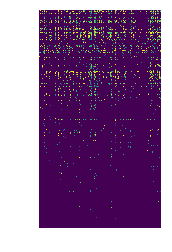

In [459]:
plt.imshow(Y)
plt.axis('off')
plt.show()

In [460]:
data_params = loadmat('ex8/ex8_movieParams.mat')
X = data_params['X']
Theta = data_params['Theta']
num_features = data_params['num_features'][0][0]
num_movies = data_params['num_movies'][0][0]
num_users = data_params['num_users'][0][0]
print(X.shape, Theta.shape)
print(num_features, num_movies, num_users)

(1682, 10) (943, 10)
10 1682 943


In [461]:
# Reduce the data set size so that this runs faster
num_users, num_movies, num_features = 4, 5, 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

### Collaborative filtering learning algorithm

In [463]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    '''
    Notes: X - num_movies x num_features matrix of movie features
           Theta - num_users x num_features matrix of user features
           Y - num_movies x num_users matrix of user ratings of movies
           R - num_movies x num_users matrix, where R(i, j) = 1 if the 
               i-th movie was rated by the j-th user
    '''
    X = params[:num_movies*num_features].reshape([num_movies, num_features])
    Theta = params[num_movies*num_features:].reshape([num_users, num_features])
    # Collaborative filtering cost function
    e = np.dot(X, Theta.T) - Y
    cost = np.sum(e[R==1]**2) / 2
    # Collaborative filtering gradient
    idx1 = np.any(R==1, axis=0)
    X_grad = np.dot(np.dot(X, Theta[idx1,:].T) - Y[:,idx1], Theta[idx1,:])
    idx2 = np.any(R==1, axis=1)
    Theta_grad = np.dot((np.dot(X[idx2,:], Theta.T) - Y[idx2,:]).T, X[idx2,:])
    return cost, X_grad, Theta_grad

In [464]:
cofiCostFunc(np.r_[X.ravel(), Theta.ravel()], Y, R, num_users, num_movies, num_features, 0)

(22.224603725685672, array([[-2.52899165,  7.57570308, -1.89979026],
        [-0.19694806,  3.0184268 , -0.29002383],
        [-0.55644309,  4.6631907 , -0.59330169],
        [ 0.02493671,  1.89555896, -0.09653612],
        [-0.53100127,  4.49714375, -0.56893395]]), array([[ -1.05680202e+01,   4.62776019e+00,  -7.16004443e+00],
        [ -1.25306693e+00,  -8.45966785e-03,  -2.39078622e+00],
        [  1.16304270e+00,  -9.91160128e-01,   1.51839686e+00],
        [  3.43544703e+00,  -1.68835487e+00,   2.70292228e+00]]))